In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

### Question Three

**2.3. Consider the challenge of classifying the likelihood of survival using the Titanic dataset. Construct a decision tree and display the structure of this tree using a graphic**

In [2]:
titanic_data = pd.read_csv('titanic3.csv')[["age", "sex", "pclass", "survived"]]
titanic_data.head()

,age,sex,pclass,survived
0,29.00,female,1,1
1,0.92,male,1,1
2,2.00,female,1,0
3,30.00,male,1,0
4,25.00,female,1,0


Prepare the data

In [3]:
# heck for NaN values
titanic_data.isna().sum()

age         263
sex           0
pclass        0
survived      0
dtype: int64

In [4]:
# Calculate the mean age
mean_age = titanic_data["age"].mean()

# Replace all the NaN values with the mean age
titanic_data["age"] = titanic_data["age"].fillna(mean_age)

#Check for NaN values
titanic_data.isna().sum()

age         0
sex         0
pclass      0
survived    0
dtype: int64

In [5]:
# Convert the gender column to float values
titanic_data["sex binary"] = titanic_data.sex.map({"female":0, "male":1})

# Validate the transformed sex column
titanic_data.head()

,age,sex,pclass,survived,sex binary
0,29.00,female,1,1,0
1,0.92,male,1,1,1
2,2.00,female,1,0,0
3,30.00,male,1,0,1
4,25.00,female,1,0,0


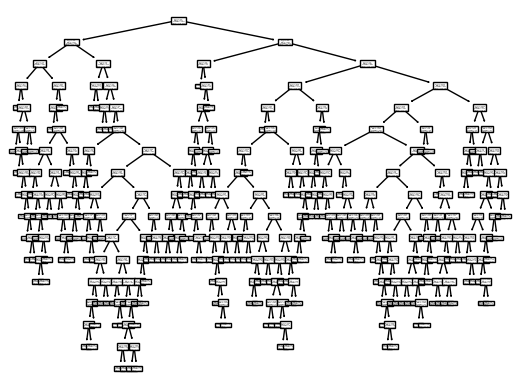

In [6]:
# Set the X and y values
X = titanic_data.drop(columns = ["survived", "sex"])
y = titanic_data[["survived"]]

# Create the model
clf = DecisionTreeClassifier(random_state = 0)

# Fit the titanic data onto the model
titanic_model = clf.fit(X, y)

# Plot the tree from the model created
tree.plot_tree(titanic_model)
plt.show()

**2.4. Evaluate the performance of the tree (before and after pruning) and provide results using cross-validation**

Create folds for the the test and training data and get the accuracy scores

In [7]:
# Create the cross-validation object with five folds
k = 5

kfolds = KFold(n_splits=k, random_state=None, shuffle=False)
scores = cross_val_score(clf, X, y, cv = kfolds, scoring = "accuracy")
print("Accuracy scores:")
scores

Accuracy scores:


array([0.75572519, 0.80152672, 0.76717557, 0.70992366, 0.78927203])

In [8]:
print(f"Average score is {scores.mean()}")
print(f"Standard deviation is {scores.std()}")

Average score is 0.7647246351379018
Standard deviation is 0.031771406682385074


Prune the tree, by using the max_depth, min_sample_split and min_samples_leaf as hyperparameters

In [9]:
# Define the paramters for the pruning
params = {'max_depth' : [2,4,6,8,10,12],
         'min_samples_split' : [2,3,4],
         'min_samples_leaf' : [1,2]}

gcv = GridSearchCV(estimator=clf, param_grid=params)
gcv.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [10]:
pruned_titanic_clf = gcv.best_estimator_

pruned_scores = cross_val_score(pruned_titanic_clf, X, y, cv = kfolds, scoring = "accuracy")
print("Pruned Scores: ")
pruned_scores

Pruned Scores: 


array([0.80534351, 0.84732824, 0.76717557, 0.70610687, 0.72413793])

In [11]:
print(f"Average score is {pruned_scores.mean()}")
print(f"Standard deviation is {pruned_scores.std()}")

Average score is 0.770018425901553
Standard deviation is 0.05181208017253168


**2.5. Compare the final tree with logistic regression and comment on the advantages and disadvantages of both. Which model is best for competing in the Kaggle competition? (5)**

Create the logistic error model and generate its confusion matrix

In [12]:
titanic_logit_model = linear_model.LogisticRegression()

logit_scores = cross_val_score(titanic_logit_model, X, y.values.ravel(), cv = kfolds, scoring = "accuracy")
print("Logit Scores: ")
logit_scores

Logit Scores: 


array([0.79389313, 0.85496183, 0.78625954, 0.73282443, 0.77011494])

In [105]:
print(f"Average score is {logit_scores.mean()}")
print(f"Standard deviation is {logit_scores.std()}")

Average score is 0.7027931326957386
Standard deviation is 0.10847394503299945


### 3. Classification using KNN

**3.3 Calculate the performance of the classifier versus the number of neighbors used and provide a graphic to display the result. What is the optimal number of neighbors using cross-validation?**

Fit the initial KNN classifier with default params, and evaluate the performance using cross validation loss

In [45]:
knn = KNeighborsClassifier(n_neighbors = 3)
# Calaulate the cross-validation loss using the mean absolute error metric
neg_init_knn_scores = cross_val_score(knn, X, y.values.ravel(), 
                                  scoring='neg_mean_absolute_error')

# Convert the negative values to positive values
init_knn_scores = np.abs(neg_init_knn_scores)
print("KNN Initial Cross Validation Scores: ")
init_knn_scores

KNN Initial Cross Validation Scores: 


array([0.41603053, 0.27862595, 0.39694656, 0.29770992, 0.33716475])

In [46]:
print(f"Average cross-validation loss is {init_knn_scores.mean()}")

Average cross-validation loss is 0.34529554561141823


Fine Tuning the classifier by varying the number of neighbours

In [53]:
num_neighbors = 1
tuned_loss_scores = []

while num_neighbors <= 20:
    tuned_knn = KNeighborsClassifier(n_neighbors = num_neighbors)
    neg_knn_scores = cross_val_score(tuned_knn, X, y.values.ravel(), 
                                  scoring='neg_mean_absolute_error')
    knn_scores = np.abs(neg_knn_scores)
    tuned_loss_scores.append(knn_scores.mean())
    num_neighbors += 1
    
tuned_loss_scores

[0.36210991196513703,
 0.3468427363926179,
 0.34529554561141823,
 0.33691907227048057,
 0.350662455032026,
 0.34378930127811413,
 0.3407358661636103,
 0.3476119446638004,
 0.3613465531865111,
 0.3499107952385131,
 0.34609400134538326,
 0.34532479307420083,
 0.3552543066888948,
 0.35372466438536454,
 0.35448509841771225,
 0.3476177941563569,
 0.35296130560673855,
 0.3491474364598871,
 0.34685736012400925,
 0.3491474364598871]

Find the optimal number of neighbors

In [60]:
minimum_val = min(tuned_loss_scores)
optimal_num_neighbors = tuned_loss_scores.index(minimum_val) + 1
print(f"Optimal number of neighbors is {optimal_num_neighbors}")

Optimal number of neighbors is 4


Plot the graph of cross-validation losses

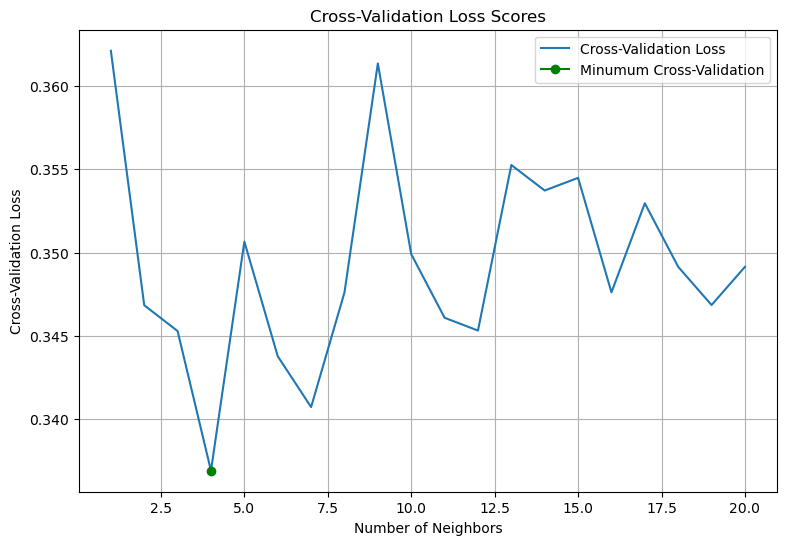

In [104]:
# Create an array for the x-values
indices = np.arange(1, len(tuned_loss_scores) + 1)

# Get the index of the minimum value
minimum_index = tuned_loss_scores.index(minimum_val) + 1

# Plot the data
plt.figure(figsize = (9,6))
plt.plot(indices, tuned_loss_scores, linestyle='-', label = "Cross-Validation Loss")
plt.title("Cross-Validation Loss Scores")
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation Loss')

# Annotate the maximum value with a marker
plt.plot(minimum_index, minimum_val, label="Minumum Cross-Validation", marker="o", color="#008000")
plt.legend()
plt.grid(True)
plt.show()

**3.4 Explain why some distance metrics are sensitive to the kind of features used. Evaluate the performance using different distance metrics**

In [85]:
#DA EXPLANATION

Evaluate the performance of the model with the optimal number of neighbors and a set of metrics

In [96]:
knn_metrics = ['chebyshev', 'euclidean', 'hamming', 'manhattan']

metrics_dict = {}
for knn_metric in knn_metrics:
    knn_test_metric = KNeighborsClassifier(n_neighbors = optimal_num_neighbors, metric = knn_metric)
    
    # Calaulate the cross-validation loss using the mean absolute error metric
    neg_metric_knn_scores = cross_val_score(knn_test_metric, X, y.values.ravel(), 
                                  scoring='neg_mean_absolute_error')
    metric_knn_scores = np.abs(neg_metric_knn_scores)
    metrics_dict[knn_metric] = metric_knn_scores.mean()
metrics_dict

{'chebyshev': 0.3995203416103653,
 'euclidean': 0.33691907227048057,
 'hamming': 0.3857681846099851,
 'manhattan': 0.3369190722704805}

**3.5 Compare the best KNN classifier with logistic regression and comment on the advantages and disadvantages of both. Which model is best for competing in the Kaggle competition?**

In [98]:
# Get the performance of the KNN classifier
knn_optimized = KNeighborsClassifier(n_neighbors = optimal_num_neighbors)

# Calaulate the cross-validation loss using the mean absolute error metric
neg_optimized_knn_scores = cross_val_score(knn_optimized, X, y.values.ravel())
optimized_knn_scores = np.abs(neg_optimized_knn_scores)
print(f"Accuracy score from KNN classifier with {optimal_num_neighbors} neighbors is {optimized_knn_scores.mean()}")

Accuracy score from KNN classifier with 4 neighbors is 0.6630809277295194


In [101]:
# Get the performance of the Logistic Regression classifier
titanic_logit_model = linear_model.LogisticRegression()
logit_scores = cross_val_score(titanic_logit_model, X, y.values.ravel(), scoring = "accuracy")
print(f"Accuracy score from Logistic Regression classifier is {logit_scores.mean()}")

Accuracy score from Logistic Regression classifier is 0.7027931326957386


In [102]:
# Calculate the rounded off scores for the comparison comment
print(round(optimized_knn_scores.mean(), 4))
print(round(logit_scores.mean(), 4))

0.6631
0.7028


The Logistic Regression classifier has an accuracy score of approximately 0.6631 while the KNN classifier has an accuracy score of approximately 0.7028. Therefore, we can conclude that the Logistic Regression classifier has a better classification accuracy.

**Advantages of KNN Classifier**
- KNN is a simple algorithm that is easy to implementm while still giving a good classification accuracy
- Because KNN models do not require training, they adapt easily to new input data. As new training samples are added, the KNN adjusts to consider the new data as all training data is stored into memory.
- KNN requires few hyperparameters during optimization, i.e., the number of neighbors and distance metric

**Disadvantages of KNN Classifier**

- KNN does not scale well. Because it is a lazy algorithm, it takes up more memory and data storage as more input is added, compared to other classifiers, which can be resource-intensive
- KNN does not perform well with high-dimensional data inputs. After the algorithm attains the optimal number of features, additional features increases the amount of classification errors, especially when the sample size is smaller. This is also referred to as the curse of dimensionality.
- KNN is prone to overfitting due to the curse of dimensionality. Setting lower values of k can overfit the data, as the algorithm has a smaller sample space to learn from. 

**Advantages of Logistic Regression Classifier**
- Logistic Regression is a simple machine learning algorithms that is easy to implement, while still providing good classification efficiency

- The predicted parameters give inference about the importance of each feature. Therefore, we can use logistic regression to find out the relationship between the features.

- The algorithm allows models to be updated easily to reflect new data using techniques like stochastic gradient descent, unlike decision trees or support vector machines.

- In a low dimensional dataset having a sufficient number of training examples, logistic regression is less prone to over-fitting.

**Disadvantages of Logistic Regression Classifier**

- If the model is trained on little training data with lots of features, it is prone to overfitting. Therefore on high dimensional datasets, Regularization techniques should be considered to avoid over-fitting. However, very high regularization factors may even lead to the model being under-fit on the training data.
- Non linear problems cannot be solved with logistic regression
- Logistic Regression requires moderate or no multicollinearity between independent variables. This means if two independent variables have a high correlation, only one of them should be used as repetition of information could lead to wrong training of parameters (weights) during minimizing the cost function

**Kaggle Suggestion**

Based on the performance above, the logistic regression classifier is appropriate for kaggle competition because it provides a higher accuracy

### 4. Regression – wine quality

The wine quality database provides information about the quality of wine. There are two
datasets, one for red wine and one for white wine, which contain quality ratings, from one to
ten, along with their physical and chemical properties. The challenge is to use these features
to predict the rating for a wine and to assess performance. It is advisable to study white and
red wine separately:

**4.1 Calculate the average of each feature for the red and white wines separately and make a comparison using a bar graph showing the two wines together. How do the results relate to common sense (or the intuition of a wine expert) based on the features that are available?**

Load and find the mean values

In [14]:
white_wine_data = pd.read_csv('winequality-white.csv', delimiter=";")
white_wine_mean = white_wine_data.mean()
white_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [15]:
red_wine_data = pd.read_csv('winequality-red.csv',  delimiter=";")
red_wine_mean = red_wine_data.mean()
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Plot the data

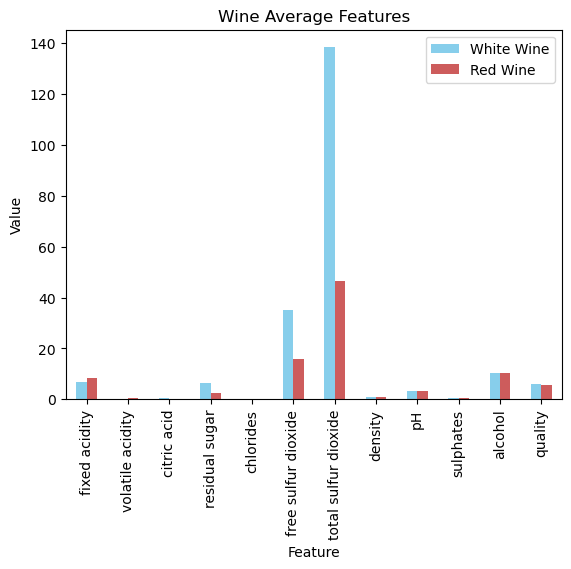

In [16]:
mean_df = pd.DataFrame({"White Wine":white_wine_mean,"Red Wine":red_wine_mean})
ax = mean_df.plot.bar(color=["SkyBlue","IndianRed"], rot=90, 
                 title="Wine Average Features")
ax.set_xlabel("Feature")
ax.set_ylabel("Value")
plt.show()

In [106]:
# INFER

**4.2 What is the correlation between each feature and the dependent variable using a separate analysis for white and red wine? Which variable is most relevant for each wine?**

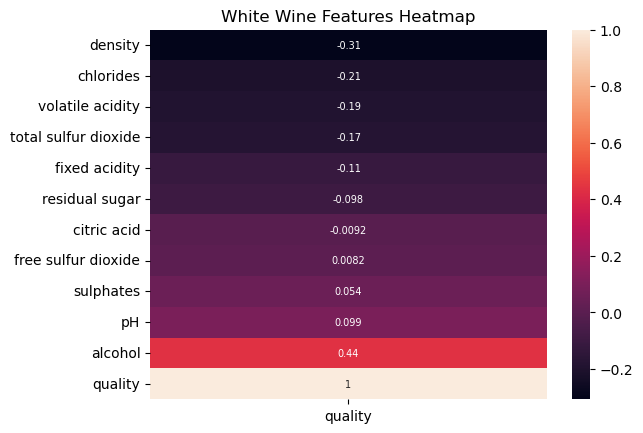

In [126]:
# Get the correlation between the predictor variables
white_wine_corr = white_wine_data.corr()[["quality"]].sort_values(by="quality")
# Plot the heatmap
plt.title("White Wine Features Heatmap")
sns.heatmap(white_wine_corr, annot = True, annot_kws={"size": 7})
plt.show()

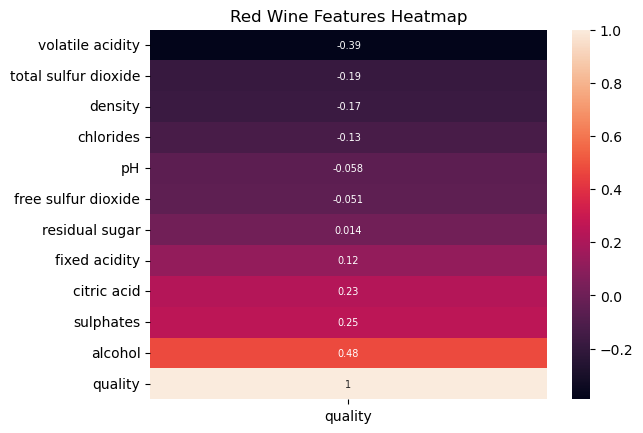

In [128]:
# Get the correlation between the predictor variables
red_wine_corr = red_wine_data.corr()[["quality"]].sort_values(by="quality")
# Plot the heatmap
plt.title("Red Wine Features Heatmap")
sns.heatmap(red_wine_corr, annot = True, annot_kws={"size": 7})
plt.show()

The most revelant feature for both white and red wine is alcohol.

**4.3 Use Lasso and cross-validation to provide a plot of MSE against lambda and the parameter estimates versus lambda. How do the features selected by LASSO compare with an approach of setting a threshold on the absolute correlation coefficient?**

Set the X and y values for the model

In [177]:
white_X = white_wine_data.drop(columns={'quality'}) 
white_y = white_wine_data[['quality']]

red_X = red_wine_data.drop(columns={'quality'}) 
red_y = red_wine_data[['quality']]

Create the lasso model

In [191]:
lasso_model = linear_model.Lasso(alpha=0.01)

Define a range of hyperparameters to get the optimal alpha value

We can maintain the starting alpha value as 0.01 for the alpha_range, as this is the best estimated alpha value

In [206]:
# Define the range of alpha values
alpha_range = np.linspace(0.01, 0.2, 30)
params = {'alpha': alpha_range}
# Find the MSE for a range of alpha values
gcv_white_wine = GridSearchCV(lasso_model, param_grid = params)
gcv_white_wine.fit(white_X, white_y)
gcv_white_wine.best_estimator_

Lasso(alpha=0.01)

In [207]:
# Find the MSE for the range of alpha values
mse_scores = []

for alpha in alpha_range:
    mse_lasso = linear_model.Lasso(alpha=alpha)
    neg_white_lasso_mse = cross_val_score(mse_lasso, white_X, white_y.values.ravel(), 
                                  scoring='neg_mean_squared_error')

    # Convert the negative values to positive values
    white_lasso_mse = np.abs(neg_white_lasso_mse)
    mse_scores.append(white_lasso_mse.mean())

Plot a graph of lambda values against MSE

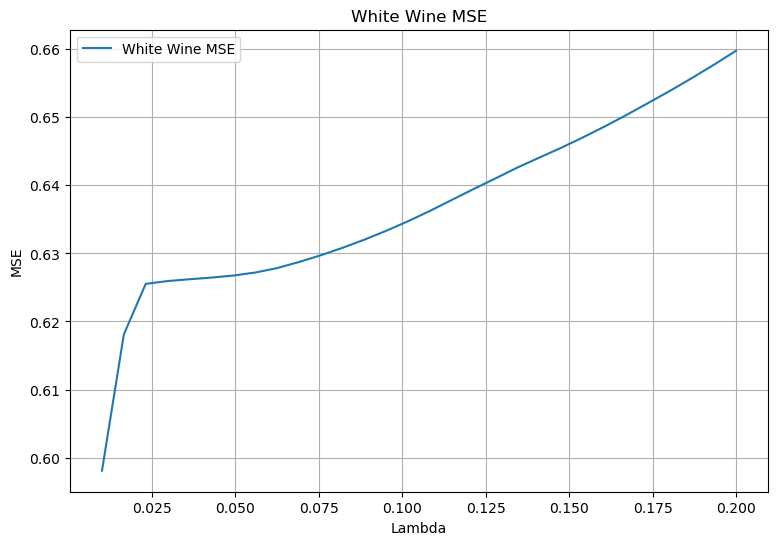

In [210]:
# Plot the data
plt.figure(figsize = (9,6))
plt.plot(alpha_range, mse_scores, linestyle='-', label = "White Wine MSE")
plt.title("White Wine MSE")
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

**4.4 Use the features identified by LASSO to construct a KNN regression model for red wine**

**4.5 What is the performance of a linear regression model and the KNN model, measured by MSE and R2? Describe the advantages and disadvantages of both models**